# Machine Learning for Refractory Alloy

## Import Function

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,accuracy_score
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
from tqdm import tqdm


## Autoencoder

In [53]:
# Load thermal_calc_data
thermal_calc_data = pd.read_csv('./data/thermal_calc_data.csv')


# elements input for autoencoder
thermal_calc_elements = thermal_calc_data.iloc[:,:10] 
thermal_calc_data

,Cr,Hf,Nb,Mo,Ta,Ti,Re,V,W,Zr,Tsol,Tliq,N(DisordPh),N(OrdPh),label
0,0.000118,0.998941,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,0.000118,2502.451483,2504.865528,1.000000,5.551115e-16,2
1,0.000007,0.000007,0.000007,0.117629,0.450665,0.000007,0.000007,0.000007,0.000007,0.431654,2097.106888,2459.654838,1.000000,4.440892e-16,1
2,0.000002,0.000002,0.167324,0.171807,0.176367,0.068896,0.170568,0.000002,0.164857,0.080175,2583.871560,3020.973714,0.909496,9.050374e-02,2
3,0.000017,0.000017,0.304175,0.298785,0.000017,0.000017,0.000017,0.000017,0.396919,0.000017,3083.701296,3161.717907,1.000000,0.000000e+00,2
4,0.000002,0.056453,0.090165,0.193152,0.149393,0.173742,0.080880,0.132468,0.073198,0.050547,2234.595472,2718.885815,1.000000,0.000000e+00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88067,0.381589,0.000008,0.000008,0.000008,0.577427,0.040928,0.000008,0.000008,0.000008,0.000008,2138.151692,2442.093468,0.648354,3.516462e-01,1
88068,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.355627,0.000007,0.644317,1542.517997,1635.777867,0.599724,4.002763e-01,0
88069,0.207365,0.000005,0.117824,0.000005,0.093911,0.143058,0.000005,0.108731,0.000005,0.329090,1615.368093,1791.171353,0.729354,2.706463e-01,0
88070,0.000020,0.000020,0.000020,0.999823,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,2895.728623,2895.940212,1.000000,4.440892e-16,2


['V', 'Nb', 'Ti', 'Mo', 'Ta', 'Hf', 'Cr', 'Zr', 'W', 'Re']


(-0.1, 1.1)

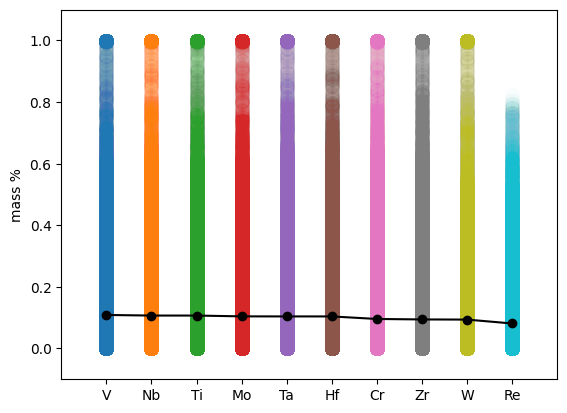

In [55]:

# Rank by average fraction
sort = thermal_calc_elements.mean().sort_values(ascending=False).reset_index()
sort_column = sort['index']
thermal_calc_elements = thermal_calc_elements[sort_column]
elements = thermal_calc_elements.columns.tolist()
print(elements)
x_index = np.zeros(len(thermal_calc_elements))
# plt.figure(figsize=(8,8))

for i in elements:
    condition = thermal_calc_elements[i] > 0.0
    plt.scatter(x_index[condition],thermal_calc_elements[i][condition],alpha=0.01,s = 100,marker='o')
    x_index+=1

plt.plot(range(len(elements)),sort[0],'ko-',label='Average Concentration')
# plt.legend()
plt.xticks(range(len(elements)),elements)
plt.ylabel('mass %')
plt.xlim(-1,len(elements))
plt.ylim(-0.1,1.1)

Text(0, 0.5, 'Count')

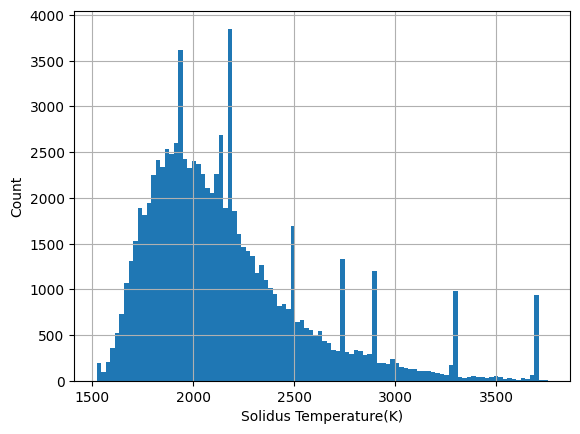

In [60]:
thermal_calc_data.Tsol.hist(bins=100)
plt.xlabel('Solidus Temperature(K)')
plt.ylabel('Count')

In [3]:
# Create Dataset object 
class Alloy_Dataset(Dataset):
    def __init__(self, elements, labels):
        super().__init__()
        assert len(labels) == len(elements)
        self.elements = elements
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
      
    def __getitem__(self, index):
        input = self.elements[index]
        target = self.labels[index]
        return input , target

data = Alloy_Dataset(thermal_calc_elements.values,thermal_calc_data['label'])


# train test split
train_ratio = 0.8
train_size = int(train_ratio * len(data))
test_size = len(data) - train_size
train_set, test_set = torch.utils.data.random_split(data, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Dataloader
train_loader = DataLoader(
    train_set, # The dataset
    batch_size=128,      # Batch size
    shuffle=True,      # Shuffles the dataset at every epoch
    pin_memory=True,   # Copy data to CUDA pinned memory                   # so that they can be transferred to the GPU very fast
    num_workers=0      # Number of worker processes for loading data.
                       # If zero, use the current process (blocks until data are loaded)
                       # Otherwise fork/spawn new processes (asynchronous load)
                       # Spawning new processes can be problematic on Windows, see:
                       # https://pytorch.org/docs/stable/notes/windows.html#usage-multiprocessing
                       )
test_loader = DataLoader(test_set,batch_size=128,shuffle=False,pin_memory=True,num_workers=0)

In [4]:
# Check cuda 
device = "cuda" if torch.cuda.is_available() else "cpu"
# 'cuda: 0' if multiple GPUs
print(device)

cuda


In [5]:
# Autoencoder Model
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(10,24),
            nn.ReLU(True),
            nn.Linear(24,48),
            nn.ReLU(True),
            nn.Linear(48,64),
            nn.ReLU(True),
            nn.Linear(64,32),
            nn.ReLU(True),
            nn.Linear(32,16),
            nn.ReLU(True),
            nn.Linear(16,8),
            nn.ReLU(True),
            nn.Linear(8,4),
            nn.ReLU(True),
            nn.Linear(4,2)
            #nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2,4),
            nn.ReLU(True),
            nn.Linear(4,8),
            nn.ReLU(True),
            nn.Linear(8,16),
            nn.ReLU(True),
            nn.Linear(16,32),
            nn.ReLU(True),
            nn.Linear(32,64),
            nn.ReLU(True),
            nn.Linear(64,48),
            nn.ReLU(True),
            nn.Linear(48,24),
            nn.ReLU(True),
            nn.Linear(24,10),
            nn.ReLU(True),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2,4)
        )

    def forward(self, input):
        en_out  = self.encoder(input)
        pred   = self.classifier(en_out)
        de_out  = self.decoder(en_out)
        return en_out,de_out, pred


In [44]:
# Put model into GPU if available
model = autoencoder().double().to(device)

# parameters set up
epochs = 300
loss_ratio = 2
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler =  lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

### Training 

In [45]:
# trainning
training_loss = []
testing_loss = []
pbar = tqdm(range(epochs))
for i in pbar:
    epoch_loss = 0.0
    for input, target in train_loader:
        model.train()
        input = input.to(device)
        target = target.to(device)
        optimizer.zero_grad() 
        encode_output,decode_output, prediction = model(input)
        loss = criterion1(decode_output,input) + 2 * criterion2(prediction,target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        pbar.set_postfix_str({'Epoch': i,'Training Loss': loss})
    epoch_loss /= len(train_loader)
    training_loss.append(epoch_loss)
    scheduler.step(epoch_loss)

 41%|████      | 123/300 [08:08<11:43,  3.98s/it, {'Epoch': 123, 'Training Loss': tensor(0.0849, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)}]

Epoch   123: reducing learning rate of group 0 to 1.0000e-04.


 53%|█████▎    | 159/300 [10:30<09:19,  3.97s/it, {'Epoch': 159, 'Training Loss': tensor(0.0342, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)}]

Epoch   159: reducing learning rate of group 0 to 1.0000e-05.


 58%|█████▊    | 174/300 [11:29<08:21,  3.98s/it, {'Epoch': 174, 'Training Loss': tensor(0.0955, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)}]

Epoch   174: reducing learning rate of group 0 to 1.0000e-06.


 61%|██████▏   | 184/300 [12:09<07:39,  3.96s/it, {'Epoch': 184, 'Training Loss': tensor(0.0610, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)}]

Epoch   184: reducing learning rate of group 0 to 1.0000e-07.


 63%|██████▎   | 190/300 [12:33<07:16,  3.97s/it, {'Epoch': 190, 'Training Loss': tensor(0.1260, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)}]

Epoch   190: reducing learning rate of group 0 to 1.0000e-08.


100%|██████████| 300/300 [19:48<00:00,  3.96s/it, {'Epoch': 299, 'Training Loss': tensor(0.1024, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)}]


Text(0, 0.5, 'Loss')

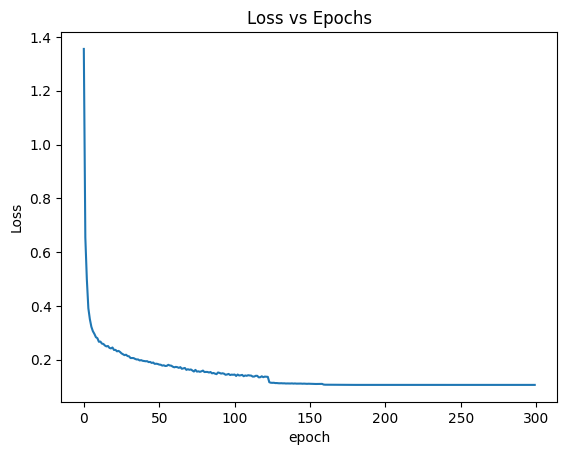

In [60]:
plt.plot(range(epochs),training_loss)
plt.title('Loss vs Epochs')
plt.xlabel('epoch')
plt.ylabel('Loss')

### Saving Model

In [54]:
saving_path = './model/ae.pth'
torch.save(model.state_dict(),saving_path)

### Loading Model

In [7]:
saving_path = './model/ae.pth'
model = autoencoder().double().to(device)
model.load_state_dict(torch.load(saving_path),strict=True)

<All keys matched successfully>

### Test the performance

In [8]:
pred_list = []
target_list = []
encode_list = []
with torch.no_grad():
    for input, target in test_loader:
        model.eval()
        input = input.to(device)
        target_list += target.detach().cpu().numpy().tolist()
        encode_output,decode_output, prediction = model(input)
        encode_list += encode_output.detach().cpu().numpy().tolist()
        pred_list += prediction.detach().cpu().numpy().tolist()
    pred_list = np.argmax(pred_list,axis=1)
    encode_array = np.array(encode_list)
print(f'Accuracy of the Model is {accuracy_score(pred_list,target_list).round(5)}')

Accuracy of the Model is 0.97701


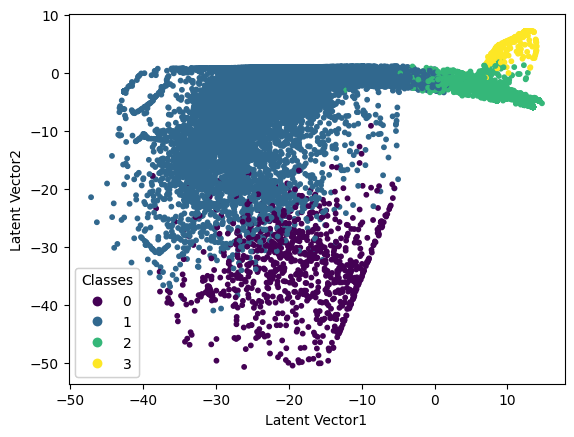

In [13]:
fig, ax = plt.subplots()
scatter = ax.scatter(encode_array[:,0],encode_array[:,1],c=target_list, label = target_list,s=10)
#plt.scatter(x,y,c = c, label = c)
legend1 = ax.legend(*scatter.legend_elements(), loc = 'best',title = 'Classes')
plt.xlabel('Latent Vector1')
plt.ylabel('Latent Vector2')
# plt.legend(loc = 'lower left')
#plt.xlim(-3,10.5)
#plt.ylim(-1,1)
ax.add_artist(legend1)

## Random Forest Regressor

In [18]:
# Load Data 
strength_name = 'YS'
strength = pd.read_csv('./data/ys_clean.csv')
include_tsol = False
# Including Solidus temperature if available
if include_tsol == False:
    strength.drop(columns=['Solidus temperature'],inplace=True)
strength

,Test temp,YS,W,Nb,Hf,Mo,Re,Zr,Ta,Ti,C,Y,Al,Si,V,Cr
0,810.927778,875.632593,9.999529e-01,0.000002,0.000001,0.000002,9.872537e-07,0.000002,0.000001,0.000004,0.000015,0.000002,0.000007,0.000007,0.000004,0.0
1,810.927778,854.948358,9.999529e-01,0.000002,0.000001,0.000002,9.872537e-07,0.000002,0.000001,0.000004,0.000015,0.000002,0.000007,0.000007,0.000004,0.0
2,1088.705556,820.474634,9.999529e-01,0.000002,0.000001,0.000002,9.872537e-07,0.000002,0.000001,0.000004,0.000015,0.000002,0.000007,0.000007,0.000004,0.0
3,1088.705556,792.895655,9.999529e-01,0.000002,0.000001,0.000002,9.872537e-07,0.000002,0.000001,0.000004,0.000015,0.000002,0.000007,0.000007,0.000004,0.0
4,1366.483333,627.421779,9.999529e-01,0.000002,0.000001,0.000002,9.872537e-07,0.000002,0.000001,0.000004,0.000015,0.000002,0.000007,0.000007,0.000004,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,298.150000,1369.000000,6.485527e-07,0.199996,0.199996,0.199996,6.403085e-07,0.000001,0.199991,0.199996,0.000010,0.000001,0.000004,0.000004,0.000002,0.0
809,1073.150000,822.000000,6.485527e-07,0.199996,0.199996,0.199996,6.403085e-07,0.000001,0.199991,0.199996,0.000010,0.000001,0.000004,0.000004,0.000002,0.0
810,1273.150000,778.000000,6.485527e-07,0.199996,0.199996,0.199996,6.403085e-07,0.000001,0.199991,0.199996,0.000010,0.000001,0.000004,0.000004,0.000002,0.0
811,1473.150000,699.000000,6.485527e-07,0.199996,0.199996,0.199996,6.403085e-07,0.000001,0.199991,0.199996,0.000010,0.000001,0.000004,0.000004,0.000002,0.0


### Visulization of data distribution

['W', 'Ta', 'Nb', 'Ti', 'Zr', 'Mo', 'Hf', 'Re', 'V', 'Al', 'C', 'Si', 'Y', 'Cr']


(-0.1, 1.1)

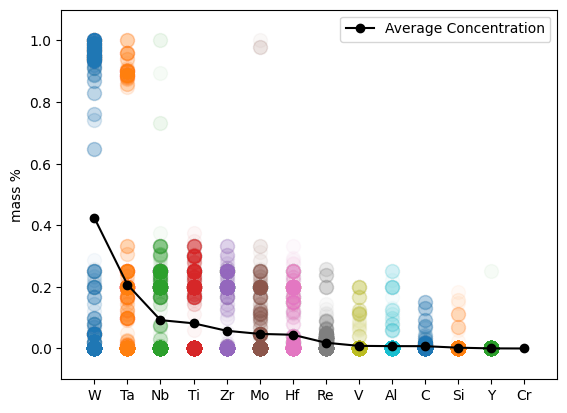

In [49]:
strength_element = strength.iloc[:,2:]
# Rank by average fraction
sort = strength_element.mean().sort_values(ascending=False).reset_index()
sort_column = sort['index']
strength_element = strength_element[sort_column]
strength_element
elements = strength_element.columns.tolist()
print(elements)
x_index = np.zeros(len(strength))
# plt.figure(figsize=(8,8))

for i in elements:
    condition = strength_element[i] > 0.0
    plt.scatter(x_index[condition],strength_element[i][condition],alpha=0.04,s = 100,marker='o')
    x_index+=1

plt.plot(range(len(elements)),sort[0],'ko-',label='Average Concentration')
plt.legend()
plt.xticks(range(len(elements)),elements)
plt.ylabel('mass %')
plt.xlim(-1,len(elements))
plt.ylim(-0.1,1.1)

Text(0, 0.5, 'Count')

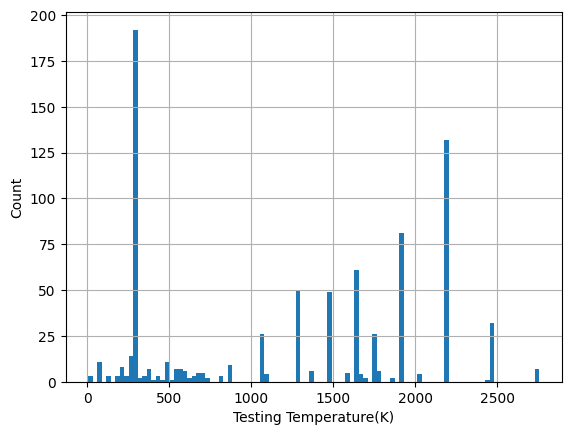

In [62]:
strength['Test temp'].hist(bins=100)
plt.xlabel('Testing Temperature(K)')
plt.ylabel('Count')

### Train and Test

R^2 value of the model is 0.8987524298673822
Mean absolut Error(MAE) of the model is 114.22729770587182


Text(0, 0.5, 'Prediction Value of YS[MPa]')

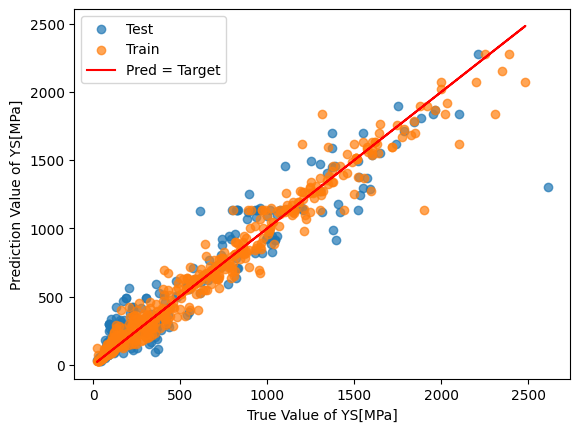

In [36]:
X = strength.drop(columns=[strength_name])
y = strength[strength_name]

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)


rf = RandomForestRegressor(n_estimators=200,random_state=42)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
print(f'R^2 value of the model is {rf.score(X_test,y_test)}')
print(f'Mean absolut Error(MAE) of the model is {mean_absolute_error(y_pred,y_test)}')

fig, ax = plt.subplots()
plt.scatter(y_test,y_pred,label='Test',alpha=0.7)
plt.scatter(y_train,y_pred_train,label='Train',alpha=0.7)
plt.plot(y_train,y_train,'r',label='Pred = Target')
plt.legend()
plt.xlabel(f'True Value of {strength_name}[MPa]')
plt.ylabel(f'Prediction Value of {strength_name}[MPa]')

## Generate New Composition

In [69]:
high_tsol = thermal_calc_data[thermal_calc_data['label']==3]
high_tsol

,Cr,Hf,Nb,Mo,Ta,Ti,Re,V,W,Zr,Tsol,Tliq,N(DisordPh),N(OrdPh),label
7,0.000017,0.000017,0.000017,0.000017,0.999848,0.000017,0.000017,0.000017,0.000017,0.000017,3289.419481,3289.907351,1.0,-2.220446e-16,3
8,0.000009,0.000009,0.222806,0.000009,0.000009,0.000009,0.000009,0.000009,0.777121,0.000009,3371.503017,3460.717574,1.0,-2.220446e-16,3
33,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.999899,0.000011,3694.461706,3694.792263,1.0,-2.220446e-16,3
51,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.999903,0.000011,3694.479268,3694.797049,1.0,-2.220446e-16,3
133,0.000084,0.000084,0.000084,0.000084,0.999248,0.000084,0.000084,0.000084,0.000084,0.000084,3287.002041,3289.407003,1.0,-4.440892e-16,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87940,0.000022,0.000022,0.000022,0.000022,0.730959,0.000022,0.000022,0.000022,0.268863,0.000022,3397.394203,3410.270622,1.0,1.110223e-16,3
87958,0.000004,0.000004,0.000004,0.256122,0.342769,0.017080,0.309863,0.000004,0.074146,0.000004,3225.693294,3311.632099,1.0,0.000000e+00,3
87988,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.999858,0.000016,3694.281286,3694.743087,1.0,1.110223e-16,3
88013,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.999865,0.000015,3694.311039,3694.751197,1.0,2.220446e-16,3


['W', 'Ta', 'Mo', 'Re', 'Nb', 'V', 'Ti', 'Zr', 'Hf', 'Cr']


(-0.1, 1.1)

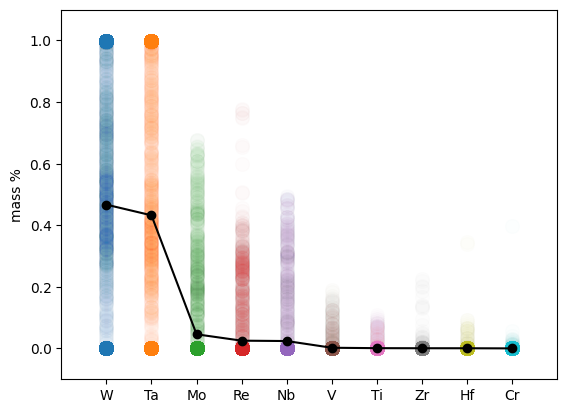

In [71]:
thermal_calc_elements = high_tsol.iloc[:,:-5]
sort = thermal_calc_elements.mean().sort_values(ascending=False).reset_index()
sort_column = sort['index']
thermal_calc_elements = thermal_calc_elements[sort_column]
elements = thermal_calc_elements.columns.tolist()
print(elements)
x_index = np.zeros(len(thermal_calc_elements))
# plt.figure(figsize=(8,8))

for i in elements:
    condition = thermal_calc_elements[i] > 0.0
    plt.scatter(x_index[condition],thermal_calc_elements[i][condition],alpha=0.01,s = 100,marker='o')
    x_index+=1

plt.plot(range(len(elements)),sort[0],'ko-',label='Average Concentration')
# plt.legend()
plt.xticks(range(len(elements)),elements)
plt.ylabel('mass %')
plt.xlim(-1,len(elements))
plt.ylim(-0.1,1.1)

### Sampling and Decoding

In [93]:
high_tsol_elements = high_tsol.iloc[:,:-5]
high_tsol_tensor = torch.Tensor(high_tsol_elements.to_numpy()).double().to(device)
latent_high_tsol = model.encoder(high_tsol_tensor).detach().cpu().numpy()
new_composition_latent = []
# Generate sample
sample_number = 1000
for i in range(sample_number):
    a,b = np.random.choice(len(latent_high_tsol),2)
    new_x = (latent_high_tsol[a][0]  + latent_high_tsol[b][0])/2 
    new_y = (latent_high_tsol[a][1]  + latent_high_tsol[b][1])/2
    new_composition_latent.append([new_x,new_y])

# Decode to composition
new_composition = model.decoder(torch.Tensor(new_composition_latent).double().to(device))
new_composition = new_composition.detach().cpu().numpy()
# Scaled fraction into sum = 1.0
new_composition_df = pd.DataFrame(new_composition)
new_composition_df.columns = high_tsol_elements.columns
new_composition_df['sum'] = new_composition_df.sum(axis=1)
for x in high_tsol_elements:
    new_composition_df[x] /= new_composition_df['sum']
new_composition_df.drop(columns=['sum'],inplace=True)
new_composition_df

,Cr,Hf,Nb,Mo,Ta,Ti,Re,V,W,Zr
0,0.0,0.0,0.087116,0.038364,0.726505,0.000000,0.000000,0.000000,0.148014,0.000000
1,0.0,0.0,0.003436,0.000000,0.973829,0.000000,0.000000,0.000000,0.022735,0.000000
2,0.0,0.0,0.120749,0.034458,0.521143,0.000000,0.113057,0.000000,0.210593,0.000000
3,0.0,0.0,0.000000,0.000000,0.607759,0.000000,0.000000,0.000000,0.392241,0.000000
4,0.0,0.0,0.109431,0.037340,0.296257,0.000000,0.217362,0.002251,0.321047,0.016311
...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.000000,0.000000,0.279776,0.000000,0.000000,0.000000,0.720224,0.000000
996,0.0,0.0,0.066961,0.000000,0.520833,0.000000,0.018951,0.000000,0.393255,0.000000
997,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
998,0.0,0.0,0.000000,0.000000,0.440823,0.000000,0.000000,0.000000,0.559177,0.000000


Text(0, 0.5, 'YS (MPa)')

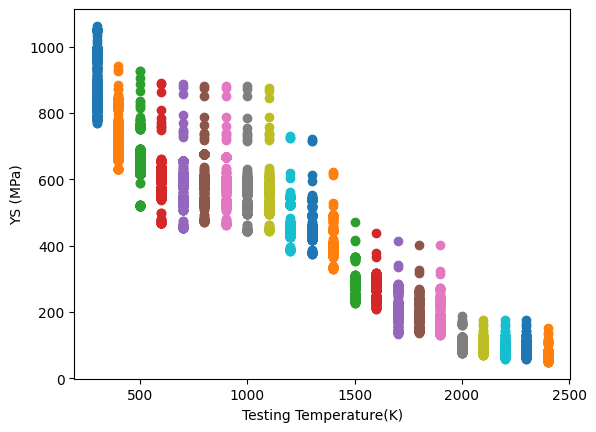

In [109]:
new_input = pd.concat([X_train.iloc[:1,:],new_composition_df])
new_input = new_input.iloc[1:,:]
new_input.fillna(0,inplace=True)
output_file = new_input.drop(columns=['Test temp'])
# Prediction for different Testing Temperature
T_test_list = np.arange(300,2500,100)
for t in T_test_list:
    new_input['Test temp'] = t
    pred = rf.predict(new_input)
    output_file[f'{strength_name}_{t}K'] = pred
    plt.scatter(t*np.ones(len(pred)),pred)
plt.xlabel('Testing Temperature(K)')
plt.ylabel(f'{strength_name} (MPa)')

### Saving New Alloy Strength Prediction

In [110]:
output_file.to_csv(f'./output/new_alloy_{strength_name}.csv',index=None)
output_file

,W,Nb,Hf,Mo,Re,Zr,Ta,Ti,C,Y,...,YS_1500K,YS_1600K,YS_1700K,YS_1800K,YS_1900K,YS_2000K,YS_2100K,YS_2200K,YS_2300K,YS_2400K
0,0.148014,0.087116,0.0,0.038364,0.000000,0.000000,0.726505,0.000000,0.0,0.0,...,284.323891,275.496347,211.613852,203.224527,187.336313,98.787104,89.060756,88.990085,88.990085,73.002608
1,0.022735,0.003436,0.0,0.000000,0.000000,0.000000,0.973829,0.000000,0.0,0.0,...,284.495538,247.051977,140.651269,141.654441,133.270144,88.255212,81.489889,81.426112,81.426112,70.074087
2,0.210593,0.120749,0.0,0.034458,0.113057,0.000000,0.521143,0.000000,0.0,0.0,...,297.910919,294.645561,259.795399,228.729432,223.453150,121.013561,110.257828,110.257828,110.257828,82.549572
3,0.392241,0.000000,0.0,0.000000,0.000000,0.000000,0.607759,0.000000,0.0,0.0,...,286.139085,274.793055,202.771391,194.456185,180.740012,98.939924,90.118180,90.047509,90.047509,74.357425
4,0.321047,0.109431,0.0,0.037340,0.217362,0.016311,0.296257,0.000000,0.0,0.0,...,311.901721,309.599614,275.270478,234.072297,227.998653,121.771754,110.865080,110.865080,110.865080,81.876470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.720224,0.000000,0.0,0.000000,0.000000,0.000000,0.279776,0.000000,0.0,0.0,...,286.553642,274.424239,203.192272,195.535179,184.296420,103.096697,93.710802,93.635304,93.635304,74.642638
996,0.393255,0.066961,0.0,0.000000,0.018951,0.000000,0.520833,0.000000,0.0,0.0,...,295.275683,274.628471,203.137354,196.113959,183.873664,117.375319,108.097130,108.010256,108.010256,79.660789
997,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,294.794843,289.232350,227.738024,173.544221,161.945865,94.732035,86.351125,75.375017,75.375017,66.170650
998,0.559177,0.000000,0.0,0.000000,0.000000,0.000000,0.440823,0.000000,0.0,0.0,...,287.153381,275.024082,203.716273,195.756960,184.280332,103.096697,93.710802,93.640130,93.640130,74.647464
